In [1]:
import tensorflow as tf
import numpy as np
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
sns.set_style('darkgrid')

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
    path='imdb.npz',
    num_words=None,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3
)

In [3]:
positive_reviews = x_train[np.where(y_train==1)]

In [4]:
len(positive_reviews)

12500

In [5]:
p = collections.Counter()

In [6]:
positive_review_length = [len(x) for x in positive_reviews]
p.update(positive_review_length)


In [7]:
p.most_common(1)

[(125, 95)]

In [8]:
negative_reviews = x_train[np.where(y_train==0)]

In [9]:
len(negative_reviews)

12500

In [10]:
n = collections.Counter()

In [11]:
negative_review_length = [len(x) for x in negative_reviews]
n.update(negative_review_length)

In [12]:
n.most_common(1)

[(132, 105)]

In [13]:
print(f"The most frequent length for positive review is {p.most_common(1)[0][0]} words and it occurs {p.most_common(1)[0][1]} times")
print(f"The most frequent length for negative review is {n.most_common(1)[0][0]} words and it occurs {n.most_common(1)[0][1]} times")

     

The most frequent length for positive review is 125 words and it occurs 95 times
The most frequent length for negative review is 132 words and it occurs 105 times


[Text(0, 0.5, 'frequency of occurence'), Text(0.5, 0, 'total word count')]

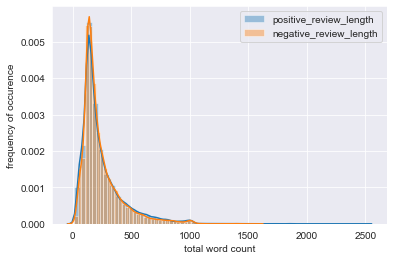

In [14]:
fig, ax = plt.subplots()
sns.distplot(positive_review_length, label='positive_review_length')
sns.distplot(negative_review_length, label='negative_review_length')
ax.legend()
ax.set(xlabel='total word count', ylabel='frequency of occurence')


# Oversampling


In [15]:
len(positive_reviews)

12500

In [16]:
y_train_pos_index = np.argwhere(y_train == 1)

In [17]:
np.random.shuffle(y_train_pos_index)

In [18]:
y_train_pos_index

array([[ 1073],
       [11742],
       [12781],
       ...,
       [15330],
       [  229],
       [10568]])

In [19]:
pos_reviews = x_train[y_train_pos_index[: int(len(y_train_pos_index)/2)]]

In [20]:
len(pos_reviews)

6250

In [21]:
pos_reviews.shape

(6250, 1)

In [22]:
# resample to x_test size
upsample_size = int(len(y_train_pos_index)/2)
upsample_size

6250

In [23]:
pos_reviews_new = np.random.choice(pos_reviews.flatten(), size=upsample_size, replace=False)

In [24]:
x_train_pos = np.concatenate((pos_reviews.flatten(), pos_reviews_new))

In [25]:
y_train_pos = np.ones(int(len(x_train_pos)))

In [26]:
y_train_pos

array([1., 1., 1., ..., 1., 1., 1.])

In [27]:
len(x_train_pos)

12500

In [28]:
x_train_pos.shape

(12500,)

In [29]:
y_train_neg = np.argwhere(y_train == 0)

In [30]:
x_train_neg = x_train[y_train_neg]
y_train_neg = np.zeros(int(len(y_train_neg)))

In [31]:
x_train_assembled = np.concatenate((x_train_pos, x_train_neg.flatten()))
y_train_assembled = np.concatenate((y_train_pos, y_train_neg))

In [32]:
x_train_assembled.shape

(25000,)

In [33]:
x_train_assembled.shape

(25000,)

In [34]:
len(x_train_assembled)

25000

In [35]:
y_train_assembled.shape


(25000,)

In [36]:
INDEX_FROM=3
word_index = tf.keras.datasets.imdb.get_word_index()
word_index = {k:(v+INDEX_FROM) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

In [37]:
reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])


In [38]:
def decode_review(review):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [39]:
len(x_test)

25000

In [40]:
x_train_assembled.shape

(25000,)

In [41]:
x_test.shape

(25000,)

In [42]:
vocab_size = 256

In [43]:
train_data = tf.keras.preprocessing.sequence.pad_sequences(x_train_assembled,
                                                          value=word_index["<PAD>"],
                                                          padding='post',
                                                          maxlen=vocab_size)

test_data = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                         value=word_index["<PAD>"],
                                                          padding='post',
                                                          maxlen=vocab_size)


In [44]:
test_data.shape

(25000, 256)

In [45]:
train_data.shape

(25000, 256)

In [46]:
y_train_assembled

array([1., 1., 1., ..., 0., 0., 0.])

In [75]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(word_index), 64),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [76]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          5669632   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               197632    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,883,777
Trainable params: 5,883,777
Non-trainable params: 0
_________________________________________________________________


In [77]:
partial_x_train, x_val, partial_y_train, y_val = train_test_split(train_data, y_train_assembled, test_size=0.2 )

In [78]:
print(partial_x_train.shape)
print(partial_y_train.shape)

print(x_val.shape)

print(y_val.shape)
print(type(partial_x_train))



(20000, 256)
(20000,)
(5000, 256)
(5000,)
<class 'numpy.ndarray'>


In [79]:
partial_x_train

array([[    1,   806,    21, ...,     0,     0,     0],
       [    1,     4,  1639, ...,     0,     0,     0],
       [ 2853,     4,    11, ...,    11,     4, 26821],
       ...,
       [    1,    14,    20, ...,     0,     0,     0],
       [ 1430,   357, 11724, ...,     6,   530,    20],
       [    1,  8220,  8846, ...,     0,     0,     0]], dtype=int32)

In [80]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [81]:
num_epochs = 5


In [82]:
H = model.fit(partial_x_train,
             partial_y_train,
             epochs=num_epochs,
             batch_size=512,
             validation_data=(x_val, y_val),
             verbose=1
             )

Epoch 1/5
40/40 [==============================] - 48s 1s/step - loss: 0.7101 - accuracy: 0.5394 - val_loss: 0.6757 - val_accuracy: 0.5634
Epoch 2/5
40/40 [==============================] - 46s 1s/step - loss: 0.6602 - accuracy: 0.6359 - val_loss: 0.6372 - val_accuracy: 0.6666
Epoch 3/5
40/40 [==============================] - 45s 1s/step - loss: 0.5000 - accuracy: 0.7919 - val_loss: 0.4343 - val_accuracy: 0.8296
Epoch 4/5
40/40 [==============================] - 44s 1s/step - loss: 0.2136 - accuracy: 0.9200 - val_loss: 0.2437 - val_accuracy: 0.9120
Epoch 5/5
40/40 [==============================] - 45s 1s/step - loss: 0.0861 - accuracy: 0.9736 - val_loss: 0.2683 - val_accuracy: 0.9030


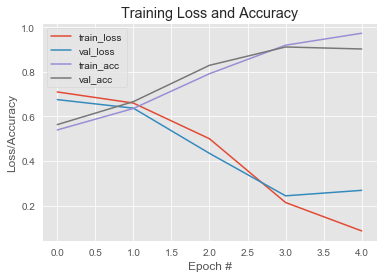

In [83]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("model_history")
plt.show()

In [84]:
preds = model.predict(test_data)

In [85]:
preds

array([[0.0769026 ],
       [0.9938052 ],
       [0.38124892],
       ...,
       [0.00141358],
       [0.5540511 ],
       [0.65343034]], dtype=float32)

In [86]:
preds = preds >= 0.5

In [87]:
cm = confusion_matrix(y_test, preds )
df_cm = pd.DataFrame(
        cm, index=['bad', 'good'], columns=['bad', 'good'], 
    )
df_cm.head()


# if you just have the collection of actuals vs predictions
# pd.crosstab(actual, predictions, rownames=['actuals'], colnames=['predictions'])

,bad,good
bad,10325,2175
good,2519,9981


In [88]:
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.83      0.81     12500
           1       0.82      0.80      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000

